# Hallucination Score Analysis

In this notebook, the hallucination scores of the methods are analyzed.

In [21]:
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import json
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.preprocessing import binarize
from scipy.stats import chi2_contingency


## Utility Functions

In [22]:
# LOADING
# load the dataframes and durations from the results folder
def load_dataframes(f):
    dataset_name = f.split("__")[0].split("_")[-4]
    model_name = f.split(dataset_name)[0].split("\\")[-1] +"_"+ f.split("__")[-1].split(".")[0]
    df = pd.read_csv(f)
    df.drop([col for col in df.columns if "answer" in col or "prompt" in col], axis=1, inplace=True)
    durations = f.split(dataset_name)[0] + "durations.csv"
    durations_df = pd.read_csv(durations) if len(glob.glob(durations)) > 0 else None
    return {"dataset_name": dataset_name, "model": model_name, "df": df, "durations": durations_df}


# ______________
# PREPROCESSING
# fix json errors in the column lbhd_score
def fix_json_errors(df):
    count = 0
    for index, row in df.iterrows():
        json_str = row['lbhd_score'].replace("'", "\"")
        while True:
            try:
                # Attempt to parse the JSON string
                json.loads(json_str)
                break  # Exit the loop if no error
            except json.JSONDecodeError as e:
                # If there's a JSONDecodeError, extract the position of the error
                error_pos = e.pos
                # print(f"Fixing error in row {index} at position: {error_pos}")
                # Add a backslash to the string in front of the error to escape the character
                json_str = json_str[:error_pos - 1] + "\\" + json_str[error_pos - 1:]
                # Replace the JSON string in the DataFrame with the corrected one
                df.at[index, 'lbhd_score'] = json_str
                count += 1
    print(f"Fixed {count} JSON errors\n")
    return df

# normalize the columns
def normalize_column(column):
    # Apply Min-Max normalization
    column = (column - column.min()) / (column.max() - column.min())
    # rescale to [0, 1] range (from [-1, 1] range)
    column = (column + 1) / 2
    return column

# process the lbhd_score column
def process_lbhd_scores(df):
    # Initialize new columns with default values
    df['lbhd_sent_avg'] = 0.0
    df['lbhd_sent_min'] = 0.0
    df['lbhd_sent_normalized_product'] = 0.0
    df['lbhd_concept_avg'] = 0.0
    df['lbhd_concept_min'] = 0.0
    df['lbhd_concept_normalized_product'] = 0.0
    # Iterate over each row to process the 'lbhd_score' column
    for index, row in df.iterrows():
        # Parse the string representation of the dictionary into an actual dictionary
        lbhd_score = json.loads(row['lbhd_score'].replace("'", "\""))        
        # Extract the low-level scores
        df.at[index, 'lbhd_sent_avg'] = lbhd_score['avg']
        df.at[index, 'lbhd_sent_min'] = lbhd_score['min']
        df.at[index, 'lbhd_sent_normalized_product'] = lbhd_score['normalized_product']        
        # Aggregate the concept-level scores
        concept_avgs = [concept[next(iter(concept))]['avg'] for concept in lbhd_score['concepts']]
        concept_mins = [concept[next(iter(concept))]['min'] for concept in lbhd_score['concepts']]
        concept_norm_prods = [concept[next(iter(concept))]['normalized_product'] for concept in lbhd_score['concepts']]        
        df.at[index, 'lbhd_concept_avg'] = np.mean(concept_avgs)
        df.at[index, 'lbhd_concept_min'] = np.min(concept_mins)
        def normalized_product(probabilities):
            adjusted_probs = [max(p, 1e-30) for p in probabilities]
            log_probs = np.log(adjusted_probs)
            score = np.exp(np.sum(log_probs) / len(adjusted_probs))
            return score
        df.at[index, 'lbhd_concept_normalized_product'] = normalized_product(concept_norm_prods)
    # Remove the 'lbhd_score' column
    df.drop('lbhd_score', axis=1, inplace=True)
    # Normalize the new columns
    df['lbhd_sent_avg'] = normalize_column(df['lbhd_sent_avg'])
    df['lbhd_sent_min'] = normalize_column(df['lbhd_sent_min'])
    df['lbhd_sent_normalized_product'] = normalize_column(df['lbhd_sent_normalized_product'])
    df['lbhd_concept_avg'] = normalize_column(df['lbhd_concept_avg'])
    df['lbhd_concept_min'] = normalize_column(df['lbhd_concept_min'])
    df['lbhd_concept_normalized_product'] = normalize_column(df['lbhd_concept_normalized_product'])
    # reverse calculation of: linear_probs = [(prob + 1) / 2 for prob in linear_probs]
    for col in df.columns:
        if "lbhd" in col:
            df[col] = (df[col] * 2) - 1
            #  invert the values 
            df[col] = df[col] * -1 + 1
    return df

# Remove rows with errors
def remove_err_rows(df):
    initial_rows = len(df)
    print(f"Initial rows: {initial_rows}")
    df = df.dropna()
    # if objects, means its a string representation of a dictionary
    for col in df.columns:
        if df[col].dtype == "object":
            # remove if 'error' is first key
            df = df[~df[col].str.contains("error")]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
        elif df[col].dtype == "float64":
            # remove if -1
            df = df[df[col] != -1]
            if len(df) < initial_rows:
                print(f"Removed {initial_rows - len(df)} rows with errors in column {col}")
            initial_rows = len(df)  # update initial_rows for the next iteration
    print(f"Final rows: {initial_rows}")
    return df

# preprocess datatypes
def preprocess_datatypes(df):
    # Convert 'ground_truth' to boolean
    df['ground_truth'] = df['ground_truth'].astype(bool)
    df['fleek_score'] = df['fleek_score'].astype(bool)
    return df

# ______________
# EVALUATION
# getting F1 optimal thresholds for each continuous column
def get_optimal_thresholds(df):
    thresholds = {}
    for col in df.columns:
        if df[col].dtype == "float64":
            y_true = df['ground_truth']
            y_pred = df[col]
            precision, recall, thresholds[col] = precision_recall_curve(y_true, y_pred)
    return thresholds

# # calculate the metrics
# def calculate_metrics(df):
#     metrics = {}
#     for col in df.columns:
#         if df[col].dtype == "float64":
#             y_true = df['ground_truth']
#             y_pred = df[col]
#             # calculate the optimal threshold
#             thresholds = get_optimal_thresholds(df)
#             threshold = thresholds[col][np.argmax(thresholds[col])]
#             # binarize the predictions
#             y_pred = binarize([y_pred], threshold=threshold)[0]  # specify the threshold as a keyword argument
#             # calculate the metrics
#             roc_auc = roc_auc_score(y_true, y_pred)
#             pr_auc = average_precision_score(y_true, y_pred)
#             f1 = f1_score(y_true, y_pred)
#             precision = precision_score(y_true, y_pred)
#             recall = recall_score(y_true, y_pred)
#             metrics[col] = {"roc_auc": roc_auc, "pr_auc": pr_auc, "f1": f1, "precision": precision, "recall": recall}
#         elif df[col].dtype == "bool":
#             y_true = df['ground_truth']
#             y_pred = df[col]
#             # calculate the metrics
#             roc_auc = roc_auc_score(y_true, y_pred)
#             pr_auc = average_precision_score(y_true, y_pred)
#             f1 = f1_score(y_true, y_pred)
#             precision = precision_score(y_true, y_pred)
#             recall = recall_score(y_true, y_pred)
#             metrics[col] = {"roc_auc": roc_auc, "pr_auc": pr_auc, "f1": f1, "precision": precision, "recall": recall}
#     return metrics



from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.preprocessing import binarize

def calculate_metrics(df, positive_class=1):
    metrics = {}
    ground_truth = df['ground_truth'].values

    for column in df.columns:
        if column == 'ground_truth':
            continue
        score = df[column].values
        
        # Check if the column is boolean
        if np.issubdtype(score.dtype, np.bool_):
            # Handle boolean scores directly
            binarized_score = score  # No need to binarize
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
        else:
            
            # Calculate AUC-ROC and AUC-PR
            auc_roc = roc_auc_score(ground_truth, score)
            auc_pr = average_precision_score(ground_truth, score)
            
            # Use precision_recall_curve to find an operational point if needed
            precision, recall, thresholds = precision_recall_curve(ground_truth, score, pos_label=positive_class)
            # Example: Choose a threshold (this could be based on a desired recall or precision level)
            # For demonstration, let's maximize F1 (default behavior in the original function)
            if thresholds.size > 0:
                f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)
                best_idx = np.argmax(f1_scores)
                threshold = thresholds[best_idx]
                binarized_score = binarize(score.reshape(1, -1), threshold=threshold).flatten()
            else:
                binarized_score = np.zeros_like(score, dtype=bool)
        
        # Calculate metrics using sklearn's average='weighted' to handle imbalance
        precision_weighted = precision_score(ground_truth, binarized_score, average='weighted')
        recall_weighted = recall_score(ground_truth, binarized_score, average='weighted')
        f1_weighted = f1_score(ground_truth, binarized_score, average='weighted')
        
        print(f"Scores for {column}:")
        print(f"AUC-ROC: {auc_roc:.4f}\nAUC-PR: {auc_pr:.4f}\nPrecision (Weighted): {precision_weighted:.4f}\nRecall (Weighted): {recall_weighted:.4f}\nF1 (Weighted): {f1_weighted:.4f}")
        
        metrics[column] = {"AUC-ROC": auc_roc, "AUC-PR": auc_pr, "Precision (Weighted)": precision_weighted, "Recall (Weighted)": recall_weighted, "F1 (Weighted)": f1_weighted}
    return metrics



# ______________
# VISUALIZATION
# plot the correlation matrix
def plot_correlation_matrix(df, model_name, dataset_name, method):
    # Ensure 'ground_truth' is the last column
    columns = [col for col in df.columns if col != 'ground_truth'] + ['ground_truth']
    df = df[columns]
    # Compute the correlation matrix
    corr = df.corr(method=method)
    # Identify the 3 strongest correlations with 'ground_truth' by absolute value, excluding itself
    strongest_corr = corr['ground_truth'].drop('ground_truth').abs().nlargest(3).index.tolist()
    fig, ax = plt.subplots(figsize=(11, 9))
    cmap = "YlGnBu"
    # Draw the heatmap with the correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=True, fmt=".2f", annot_kws={"size": 7},
                mask=np.triu(np.ones_like(corr, dtype=bool)))  # Mask for the upper triangle
    # Highlight the columns and rows of the 3 strongest correlations
    for strong_corr in strongest_corr:
        if not np.tril(np.ones_like(corr, dtype=bool))[df.columns.get_loc(strong_corr), len(df.columns) - 1]:
            ax.add_patch(Rectangle((df.columns.get_loc(strong_corr), len(df.columns) - 1), 1, 1, fill=False, edgecolor='red', lw=3))
        if not np.tril(np.ones_like(corr, dtype=bool))[len(df.columns) - 1, df.columns.get_loc(strong_corr)]:
            ax.add_patch(Rectangle((len(df.columns) - 1, df.columns.get_loc(strong_corr)), 1, 1, fill=False, edgecolor='red', lw=3))
    ax.set_xticks(np.arange(len(corr.columns)) + .5)
    ax.set_yticks(np.arange(len(corr.columns)) + .5)
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticklabels(corr.columns)
    # Set title with model and dataset names
    dataset_name = "Natural Questions" if dataset_name == "nqopen" else "XSum" if dataset_name == "xsum" else dataset_name
    plt.title(f'{method}Correlation Matrix for {model_name}\non dataset {dataset_name}', fontsize=16, pad=20)
    plt.title(f'{method.capitalize()} Correlation Matrix for {model_name}\non dataset {dataset_name}', fontsize=16, pad=20)
    # Adjust layout to fit everything
    plt.tight_layout()
    # Display the plot
    plt.show()

def plot_categorical(df):
    # include boolean columns
    cat_cols = df[df.columns[df.dtypes == 'bool']].columns
    if 'ground_truth' in cat_cols:
        for col in cat_cols:
            if col != 'ground_truth':
                tab = pd.crosstab(df[col], df['ground_truth'])
                chi2, p, dof, ex = chi2_contingency(tab)
                if p < 0.01:
                    plt.figure(figsize=(10, 6))
                    sns.barplot(x=tab.index, y=tab['ground_truth'], data=tab)
                    plt.title(f'{col} vs ground_truth (Chisq P = {p:.2e})')
                    plt.xlabel(f'{col}')
                    plt.ylabel('Proportion')
                    plt.xticks(rotation=90)
                    plt.show()
    else:
        print("There is no 'ground_truth' categorical variable")

# show unique values for each column
def show_unique_values(df):
    for col in df.columns:
        print(f"{col}: {df[col].unique()}")


# ______________
# MAIN
def main():
    # Load the dataframes and durations
    files = glob.glob("results/*with_ground_truths*.csv")
    dataframes = [load_dataframes(f) for f in files]
    print(f"Found {len(dataframes)} CSVs with scores and ground truths for analysis:\n")
    for dataset in dataframes:
        print(f"Dataset: {dataset['dataset_name']}")
        print(f"LLM: {dataset['model']}")
        print(f"Shape: {dataset['df'].shape}\n")
    # Remove rows with errors
    for df in dataframes:
        df['df'] = remove_err_rows(df['df'])
    # Fix the JSON errors in the 'lbhd_score' column
    for df in dataframes:
        df['df'] = fix_json_errors(df['df'])
    # Process the 'lbhd_score' column
    for df in dataframes:
        df['df'] = process_lbhd_scores(df['df'])
    # Preprocess datatypes
    for df in dataframes:
        df['df'] = preprocess_datatypes(df['df'])
    # Calculate the metrics
    for df in dataframes:
        df['metrics'] = calculate_metrics(df['df'])
    # Plot the correlation matrix
    for df in dataframes:
        plot_correlation_matrix(df['df'], df['model'], df['dataset_name'], "pearson")
    # Plot the categorical variables
    # TODO: add to the function

## Running the Analysis

In [23]:
# main()

## Loading the scores

In [24]:
# load datasets
# find all csvs with scores and ground truths
files = glob.glob("results/*with_ground_truths*.csv")

# load all csvs into a list of dataframes
datasets = [load_dataframes(f) for f in files]

print(f"Found {len(datasets)} CSVs with scores and ground truths for analysis:\n")
for dataset in datasets:
    print(f"Dataset: {dataset['dataset_name']}")
    print(f"LLM: {dataset['model']}")
    print(f"Shape: {dataset['df'].shape}\n")

Found 6 CSVs with scores and ground truths for analysis:

Dataset: nqopen
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: xsum
LLM: openai__gpt-3-5-turbo
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai_2__mistralai_Mistral-7B-Instruct-v0-1
Shape: (80, 6)

Dataset: nqopen
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)

Dataset: xsum
LLM: togetherai__mistralai_Mixtral-8x7B-Instruct-v0-1
Shape: (80, 6)



In [25]:
test_df = datasets[0]["df"]
test_df.head(2)

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,lbhd_score,ground_truth
0,0.0,0.049175,0.167182,0.0,"{'avg': 0.9644255675958286, 'normalized_produc...",0.0
1,0.0,0.992679,0.348210,0.0,"{'avg': 0.9406606117559376, 'normalized_produc...",0.0


In [26]:
# remove rows with errors
test_df = remove_err_rows(test_df)

Initial rows: 80
Removed 7 rows with errors in column fleek_score
Final rows: 73


In [27]:
import time

# process LBHD scores
start = time.time()
test_df = fix_json_errors(test_df)
# test_df = fix_json_errors_optimized(test_df)
print(f"Fixing JSON errors took {time.time() - start:.2f} seconds")
start = time.time()
test_df = process_lbhd_scores(test_df)   # aggregate concept-level scores and normalize (min-max)
# test_df = process_lbhd_scores_optimized(test_df)
print(f"Processing LBHD scores took {time.time() - start:.2f} seconds")
# preprocess datatypes
test_df = preprocess_datatypes(test_df)
# save processed dataframe
test_df.to_csv("results/processed.csv", index=False)
show_unique_values(test_df)
test_df.head(3)

Fixed 10 JSON errors

Fixing JSON errors took 0.01 seconds
Processing LBHD scores took 0.02 seconds
fleek_score: [False  True]
selfcheck_nli_score: [4.91749291e-02 9.92679298e-01 2.41146288e-03 2.03146094e-03
 2.00661489e-01 4.10186668e-03 1.52877218e-03 1.35964127e-03
 9.59785096e-04 7.98838152e-01 1.01831437e-03 5.78699028e-04
 1.30758034e-01 2.58651651e-01 7.16527415e-04 1.10779945e-03
 1.67987025e-03 1.41934393e-03 2.28502277e-01 4.97616825e-02
 8.06014839e-04 2.53827940e-03 6.21846784e-04 5.15373913e-04
 6.01321630e-01 3.63701946e-01 1.15547969e-03 3.48339840e-03
 1.51860984e-03 3.00942920e-04 1.03951758e-03 1.17863009e-01
 2.07814691e-01 1.97744674e-01 9.85378397e-01 8.35240830e-04
 4.86882543e-03 1.88105949e-03 1.12720227e-01 8.47060679e-04
 9.25612287e-04 1.17864334e-03 1.38143548e-03 7.54997809e-04
 8.54926325e-02 2.51788744e-01 1.15618243e-01 6.70115155e-04
 9.99296808e-01 1.29257360e-03 1.73436904e-03 1.21426850e-03
 3.48574419e-03 9.98639214e-01 3.70484614e-03 1.20444136e-0

,fleek_score,selfcheck_nli_score,selfcheck_bert_score,lm_v_lm_score,ground_truth,lbhd_sent_avg,lbhd_sent_min,lbhd_sent_normalized_product,lbhd_concept_avg,lbhd_concept_min,lbhd_concept_normalized_product
0,False,0.049175,0.167182,0.0,False,0.209095,0.226733,0.161475,0.093800,0.238065,0.076432
1,False,0.992679,0.348210,0.0,False,0.354000,0.628277,0.327028,0.155962,0.167257,0.121586
2,False,0.002411,0.260011,0.0,False,0.233051,0.332993,0.188421,0.066523,0.139901,0.051941


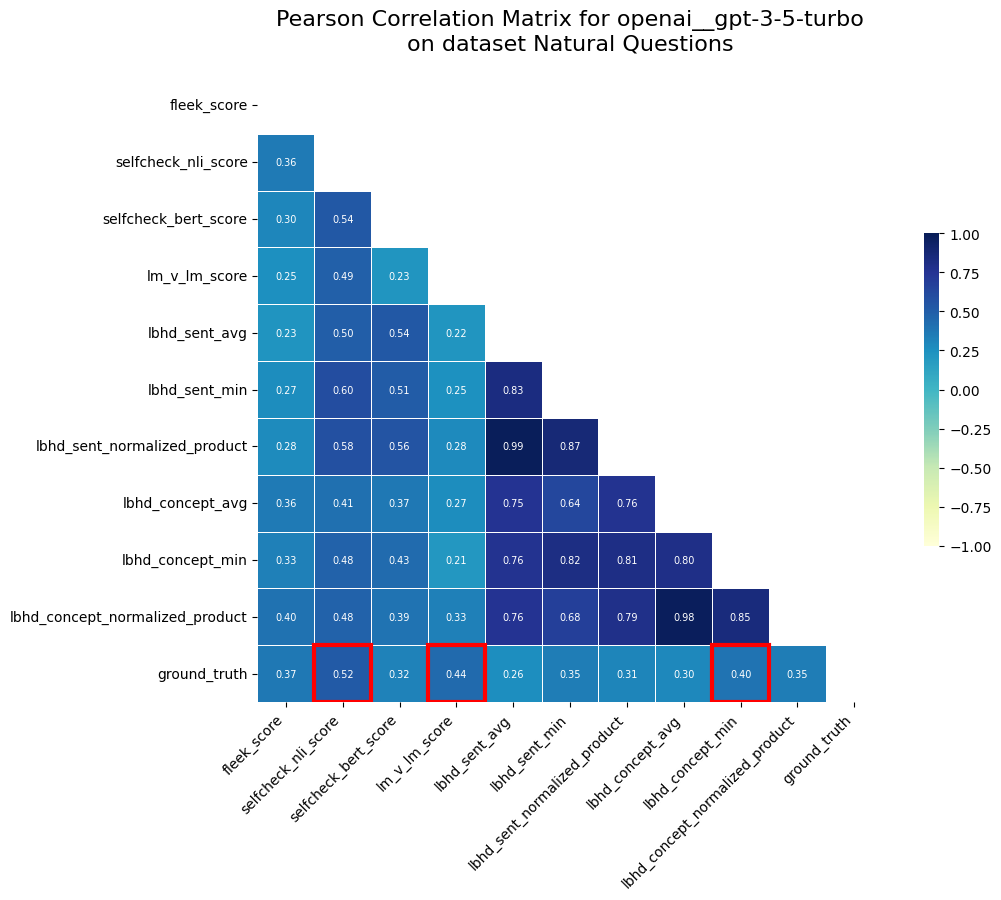

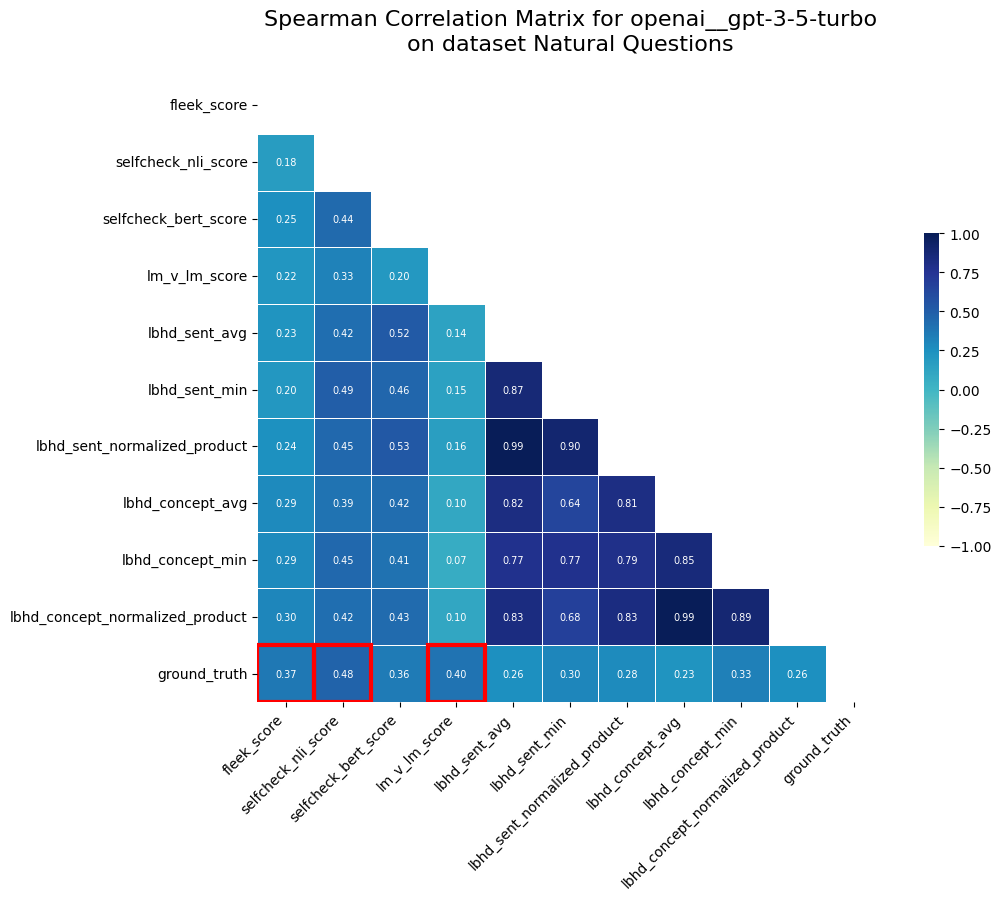

In [28]:
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "pearson")
plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "spearman")
# plot_correlation_matrix(test_df, datasets[0]["model"], datasets[0]["dataset_name"], "kendall")

In [29]:
# Calculate metrics for the 'lbhd_concept_min' column
metrics = calculate_metrics(test_df)
columns = test_df.columns
# Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics).T

# Define a function to highlight the top 2 values in each column
def highlight_top2(s):
    is_top2 = s.isin(s.nlargest(2))
    return ['background-color: yellow' if v else '' for v in is_top2]

# Apply the style to the DataFrame
metrics_df.style.apply(highlight_top2)


Scores for fleek_score:
AUC-ROC: 0.6808
AUC-PR: 0.3267
Precision (Weighted): 0.8166
Recall (Weighted): 0.8219
F1 (Weighted): 0.8191
Scores for selfcheck_nli_score:
AUC-ROC: 0.8590
AUC-PR: 0.6340
Precision (Weighted): 0.8540
Recall (Weighted): 0.8493
F1 (Weighted): 0.8515
Scores for selfcheck_bert_score:
AUC-ROC: 0.7679
AUC-PR: 0.3830
Precision (Weighted): 0.8017
Recall (Weighted): 0.7260
F1 (Weighted): 0.7516
Scores for lm_v_lm_score:
AUC-ROC: 0.6923
AUC-PR: 0.4036
Precision (Weighted): 0.6755
Recall (Weighted): 0.8219
F1 (Weighted): 0.7416
Scores for lbhd_sent_avg:
AUC-ROC: 0.6936
AUC-PR: 0.3150
Precision (Weighted): 0.7716
Recall (Weighted): 0.7260
F1 (Weighted): 0.7445
Scores for lbhd_sent_min:
AUC-ROC: 0.7269
AUC-PR: 0.4849
Precision (Weighted): 0.8015
Recall (Weighted): 0.7671
F1 (Weighted): 0.7808
Scores for lbhd_sent_normalized_product:
AUC-ROC: 0.7090
AUC-PR: 0.4018
Precision (Weighted): 0.7767
Recall (Weighted): 0.7397
F1 (Weighted): 0.7551
Scores for lbhd_concept_avg:
AUC-ROC

c:\Users\sbene\miniconda3\envs\hdetect\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,AUC-ROC,AUC-PR,Precision (Weighted),Recall (Weighted),F1 (Weighted)
fleek_score,0.680769,0.326660,0.816640,0.821918,0.819092
selfcheck_nli_score,0.858974,0.634029,0.854025,0.849315,0.851472
selfcheck_bert_score,0.767949,0.382956,0.801668,0.726027,0.751626
lm_v_lm_score,0.692308,0.403583,0.675549,0.821918,0.741580
lbhd_sent_avg,0.693590,0.315026,0.771609,0.726027,0.744503
lbhd_sent_min,0.726923,0.484907,0.801508,0.767123,0.780841
lbhd_sent_normalized_product,0.708974,0.401817,0.776671,0.739726,0.755058
lbhd_concept_avg,0.671795,0.423719,0.818326,0.561644,0.608585
lbhd_concept_min,0.750000,0.500346,0.800723,0.794521,0.797462
lbhd_concept_normalized_product,0.693590,0.441587,0.821077,0.575342,0.621866


<Axes: xlabel='lbhd_concept_min', ylabel='Count'>

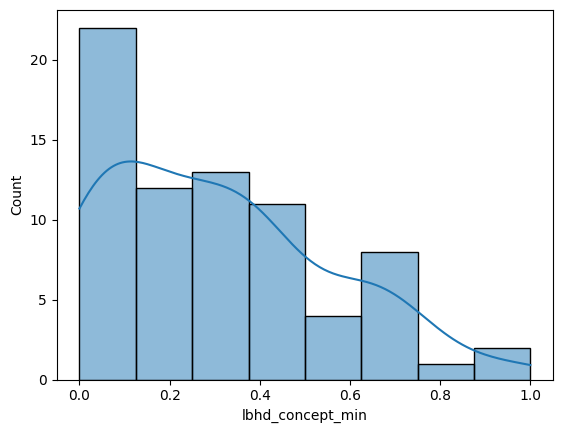

In [30]:
# look at lbhf_concept_min: distribution of scores
sns.histplot(test_df['lbhd_concept_min'], kde=True)

In [31]:
plot_categorical(test_df)

KeyError: 'ground_truth'

<Figure size 1000x600 with 0 Axes>